In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            Swish(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, kernel_size, stride, se_ratio=0.25):
        super(MBConvBlock, self).__init__()
        self.stride = stride
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        hidden_dim = in_channels * expand_ratio
        self.expand_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.expand_bn = nn.BatchNorm2d(hidden_dim)
        self.expand_swish = Swish()

        self.depthwise_conv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size,
                                       stride=stride, padding=kernel_size // 2, groups=hidden_dim, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(hidden_dim)
        self.depthwise_swish = Swish()

        self.se_block = SEBlock(hidden_dim, int(in_channels * se_ratio)) if se_ratio > 0 else None

        self.project_conv = nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        x = self.expand_swish(self.expand_bn(self.expand_conv(x)))

        x = self.depthwise_swish(self.depthwise_bn(self.depthwise_conv(x)))

        if self.se_block is not None:
            x = self.se_block(x)

        x = self.project_bn(self.project_conv(x))

        if self.use_res_connect:
            x += identity

        return x

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=7):
        super(EfficientNetB0, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.swish = Swish()
        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, 1, 3, 1),
            MBConvBlock(16, 24, 6, 3, 2),
            MBConvBlock(24, 40, 6, 5, 2),
            MBConvBlock(40, 80, 6, 3, 2),
            MBConvBlock(80, 112, 6, 5, 1),
            MBConvBlock(112, 192, 6, 5, 2),
            MBConvBlock(192, 320, 6, 3, 1),
        )
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1280, num_classes)
    def forward(self, x):
        x = self.swish(self.bn1(self.conv1(x)))
        x = self.blocks(x)
        x = self.swish(self.bn2(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetB0().to(device)

train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
    transforms.ToTensor(),
])


valid_transform = transforms.Compose([
    transforms.ToTensor(),
])


root_dir = '/kaggle/input/fer2013'  
train_dataset = datasets.ImageFolder(root=root_dir + '/train', transform=train_transform)
valid_dataset = datasets.ImageFolder(root=root_dir + '/train', transform=valid_transform)
test_dataset = datasets.ImageFolder(root=root_dir + '/test', transform=valid_transform)


train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
validloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=7):
        super(EfficientNetModel, self).__init__()
        self.base_model = EfficientNetB0()
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-4])
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(1280, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.batchnorm1(self.fc1(x))))
        x = self.dropout(self.relu(self.batchnorm2(self.fc2(x))))
        x = self.fc3(x)
        return x


model = EfficientNetModel().to(device)



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min', verbose=True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F

trl, tra, tel, tea = [], [], [], []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss += loss.item()
        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()


    train_accuracy = correct_train / total_train
    tra.append(train_accuracy)
    
    # Append training loss
    train_loss /= len(trainloader)
    trl.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted_valid = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted_valid.eq(labels).sum().item()
        valid_accuracy = correct_valid / total_valid
        tea.append(valid_accuracy)
        valid_loss /= len(validloader)
        tel.append(valid_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {100 * valid_accuracy:.2f}%')
        scheduler.step(valid_loss)
df_metrics = pd.DataFrame({'Train Loss': trl, 'Train Accuracy': tra, 'Validation Loss': tel, 'Validation Accuracy': tea})
print(df_metrics)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch [1/100], Train Loss: 1.8313, Train Accuracy: 25.24%, Validation Loss: 1.7612, Validation Accuracy: 28.58%
Epoch [2/100], Train Loss: 1.7194, Train Accuracy: 30.77%, Validation Loss: 1.7417, Validation Accuracy: 31.47%
Epoch [3/100], Train Loss: 1.6286, Train Accuracy: 35.96%, Validation Loss: 1.6039, Validation Accuracy: 36.90%
Epoch [4/100], Train Loss: 1.5670, Train Accuracy: 38.81%, Validation Loss: 1.5490, Validation Accuracy: 40.39%
Epoch [5/100], Train Loss: 1.5244, Train Accuracy: 40.68%, Validation Loss: 1.4633, Validation Accuracy: 42.37%
Epoch [6/100], Train Loss: 1.4838, Train Accuracy: 42.26%, Validation Loss: 1.4678, Validation Accuracy: 43.33%
Epoch [7/100], Train Loss: 1.4545, Train Accuracy: 43.83%, Validation Loss: 1.4300, Validation Accuracy: 44.64%
Epoch [8/100], Train Loss: 1.4306, Train Accuracy: 44.59%, Validation Loss: 1.4044, Validation Accuracy: 45.02%
Epoch [9/100], Train Loss: 1.4025, Train Accuracy: 45.87%, Validation Loss: 1.3831, Validation Accuracy:

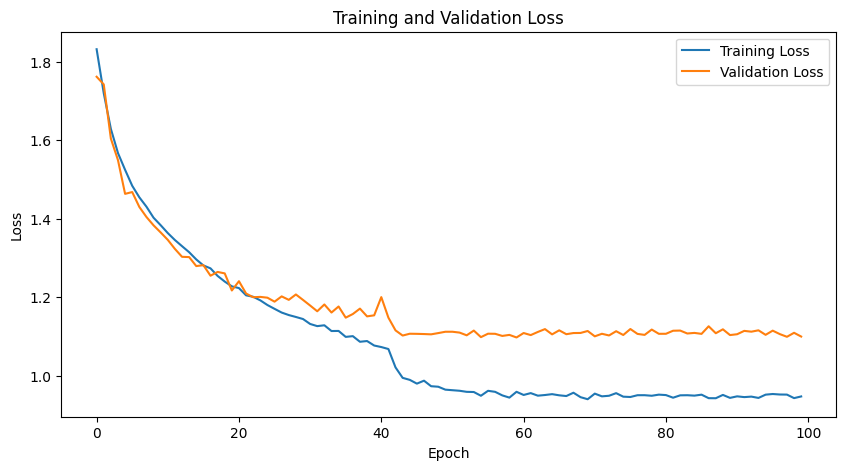

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(trl, label='Training Loss')
plt.plot(tel, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


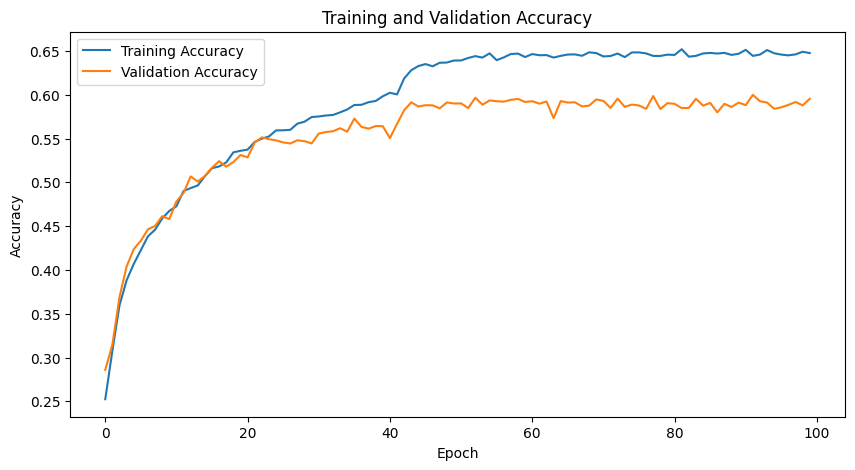

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(tra, label='Training Accuracy')
plt.plot(tea, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Correctly Predicted Images:


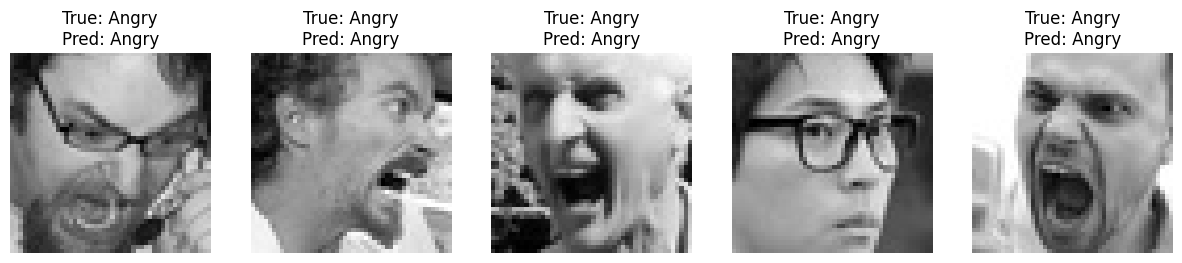

Incorrectly Predicted Images:


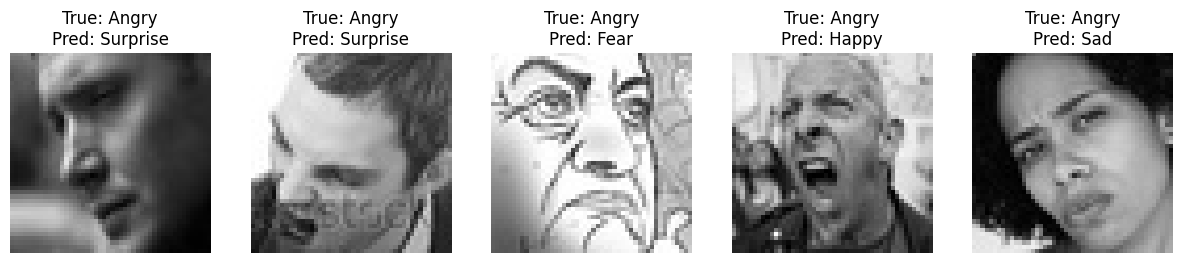

In [9]:
model.eval()
correct = 0
total = 0
correct_images_info = []
incorrect_images_info = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        correct_mask = predicted.eq(labels)
        incorrect_mask = ~correct_mask

        correct_images = inputs[correct_mask]
        correct_labels = labels[correct_mask]
        correct_predictions = predicted[correct_mask]

        incorrect_images = inputs[incorrect_mask]
        incorrect_labels = labels[incorrect_mask]
        incorrect_predictions = predicted[incorrect_mask]

        # Store information about correctly predicted images
        for i in range(len(correct_images)):
            correct_images_info.append({
                'image': correct_images[i].cpu().numpy(),
                'true_label': correct_labels[i].item(),
                'predicted_label': correct_predictions[i].item()
            })

        # Store information about incorrectly predicted images
        for i in range(len(incorrect_images)):
            incorrect_images_info.append({
                'image': incorrect_images[i].cpu().numpy(),
                'true_label': incorrect_labels[i].item(),
                'predicted_label': incorrect_predictions[i].item()
            })

        break  # Only process the first batch

# Print some correctly predicted images
print("Correctly Predicted Images:")
plt.figure(figsize=(15, 3))
for i in range(min(5, len(correct_images_info))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(correct_images_info[i]['image'].transpose(1, 2, 0).squeeze())
    true_label = class_names[correct_images_info[i]["true_label"]]
    pred_label = class_names[correct_images_info[i]["predicted_label"]]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

# Print some incorrectly predicted images
print("Incorrectly Predicted Images:")
plt.figure(figsize=(15, 3))
for i in range(min(5, len(incorrect_images_info))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(incorrect_images_info[i]['image'].transpose(1, 2, 0).squeeze())
    true_label = class_names[incorrect_images_info[i]["true_label"]]
    pred_label = class_names[incorrect_images_info[i]["predicted_label"]]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

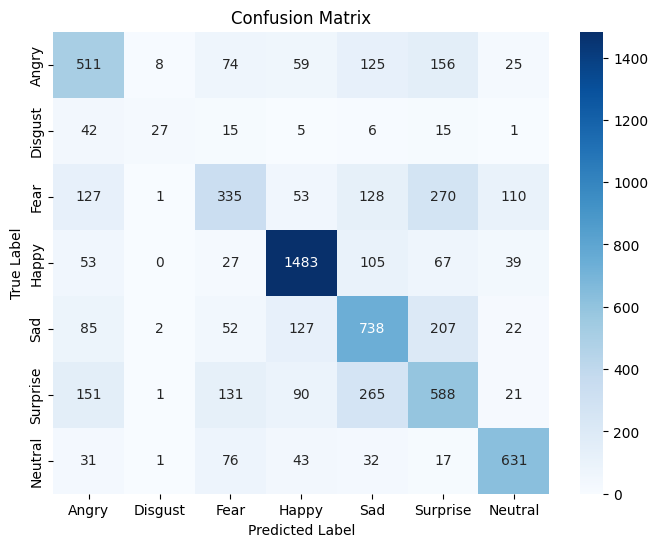

In [12]:
from sklearn.metrics import confusion_matrix
model.eval()
with torch.no_grad():
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        all_labels = []
        all_predictions = []
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted_valid = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted_valid.eq(labels).sum().item()

            # Store labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_valid.cpu().numpy())
import seaborn as sn
import pandas as pd
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_df = pd.DataFrame(conf_matrix, index=class_names.values(), columns=class_names.values())
plt.figure(figsize=(8, 6))
sn.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [13]:
torch.save(model.state_dict(), 'EfficientNet.pth')